# Training neural networks with Koopman Operators

NOTE: Not a very optimized code, just a quick implementation to check details

In [1]:
import time
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from jax import flatten_util

/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Hyper-parameters:**

In [2]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 1.
t1, t2, T = 3, 5, 1
OPTIM = 'ADADELTA'

key = jax.random.PRNGKey(0)

**Loading MNIST data:**

In [3]:
normalise_data = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),])

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,)

test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,)

trainloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

**The neural network:**

In [4]:
class MNISTClassifier(eqx.Module):
    
    layers: list
    activations: list

    def __init__(self, 
                 key: jax.random.PRNGKey):
        
        keys = jax.random.split(key, 4)
        self.layers = [eqx.nn.Linear(784, 20, key=keys[0]),
                       eqx.nn.Linear(20, 20, key=keys[1]),
                       eqx.nn.Linear(20, 20, key=keys[2]),
                       eqx.nn.Linear(20, 10, key=keys[3])]
        self.activations = [jax.nn.relu, 
                            jax.nn.relu, 
                            jax.nn.relu, 
                            jax.nn.log_softmax]

    def __call__(self, x):
        x = x.flatten()
        for layer, activation in zip(self.layers, self.activations):
            x = layer(x)
            x = activation(x)
        return x

**Functions for conventional training:**

In [5]:
def cross_entropy(y, pred_y):
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

def loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)

@eqx.filter_jit
def make_step(model, x, y, optim, opt_state):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

def compute_accuracy(model, x, y):
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

@eqx.filter_jit
def evaluate(model, testloader):
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)

**Functions for node-wise Koopman training:**

In [6]:
def tree_stack(trees):
    return jax.tree_util.tree_map(lambda *v: jnp.stack(v), *trees)

def tree_unstack(tree):
    leaves, treedef = jax.tree_util.tree_flatten(tree)
    return [treedef.unflatten(leaf) for leaf in zip(*leaves, strict=True)]

def ravel_pytree(pytree):
    flat, meta = flatten_util.ravel_pytree(pytree)
    return flat, meta

def unravel_pytree(flat, meta):
    tree_def = meta.args[0]
    splits, shapes = meta.args[1].args
    leaves = [param.reshape(shape) for shape,param in \
              zip(shapes, jnp.split(flat, splits))]
    return jax.tree_util.tree_unflatten(tree_def, leaves)

def build_fullnode_koopmans(captured_params):
    stacked_captured_params = tree_stack(captured_params)
    flat, tdef = jax.tree_util.tree_flatten(stacked_captured_params)
    koopmans  = []
    for n, (weight, bias) in enumerate(zip(flat[::2], flat[1::2])):
        layer_koopmans = []
        for i in range(bias.shape[-1]):
            F_full = jnp.hstack((weight[:,i,:], bias[:,i].reshape(-1,1))).T
            U = F_full[:, 1:] @ jnp.linalg.pinv(F_full[:, :-1])
            layer_koopmans.append(U)
        koopmans.append(layer_koopmans)
    return koopmans

@eqx.filter_jit
def node_koopman_update(model, koopmans):
    params, static = eqx.partition(model, eqx.is_array)
    flat, tdef = jax.tree_util.tree_flatten(params)
    new_flat = []
    for layer_koopman, weight, bias in zip(koopmans, flat[::2], flat[1::2]):
        _new_weight, _new_bias = [], []
        ## Todo: TREEMAPIFY THIS
        for i in range(bias.shape[0]):
            node = jnp.hstack((weight[i,:], bias[i]))
            node_update = layer_koopman[i] @ node
            weight_next, bias_next = node_update[:-1], node_update[-1]
            _new_weight.append(weight_next) 
            _new_bias.append(bias_next)
        
        new_weight = jnp.vstack(_new_weight)
        new_bias = jnp.hstack(_new_bias)
        new_flat.append(new_weight)
        new_flat.append(new_bias)
    new_params = jax.tree_util.tree_unflatten(treedef=tdef, leaves=new_flat)
    return eqx.combine(new_params, static)

**Initialize things:**

In [7]:
key, model_key = jax.random.split(key)
model = MNISTClassifier(model_key)
optim = optax.adadelta(LEARNING_RATE)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

**Burn-in t1 epochs**

In [8]:
for epoch in range(t1):
    for step, (x, y) in enumerate(trainloader):
        x, y  = x.numpy(), y.numpy()
        model, opt_state, train_loss = make_step(model, x, y, optim, opt_state)

**From t1 to t2 - Record all states**

In [9]:
captured_params = []
for epoch in range(t1, t2):
    for step, (x, y) in enumerate(trainloader):
        x, y  = x.numpy(), y.numpy()
        model, opt_state, train_loss = make_step(model, x, y, optim, opt_state)
        params, static = eqx.partition(model, eqx.is_array)
        captured_params.append(params)
 
koopmans = build_fullnode_koopmans(captured_params)
model_chckpt = model
model_k = model_chckpt

**Final T epochs, actual comparison**

In [10]:
train_losses = []
conv_times, koop_times = [], []
conv_test_accs, koop_test_accs = [], []
conv_test_losses, koop_test_losses = [], []

for epoch in range(t2, t2 + T):
    for step, (x, y) in enumerate(trainloader):
        x, y  = x.numpy(), y.numpy()
        start = time.time()
        model, opt_state, train_loss = make_step(model, x, y, optim, opt_state)
        mid = time.time()
        model_k = node_koopman_update(model_k, koopmans)
        end = time.time()
        
        conv_test_loss, conv_test_accuracy = evaluate(model, testloader)
        koop_test_loss, koop_test_accuracy = evaluate(model_k, testloader)

        train_losses.append(train_loss)
        conv_times.append(mid-start)
        koop_times.append(end-mid)
        conv_test_accs.append(conv_test_accuracy)
        koop_test_accs.append(koop_test_accuracy)
        conv_test_losses.append(conv_test_loss)
        koop_test_losses.append(koop_test_loss)

**Results:**

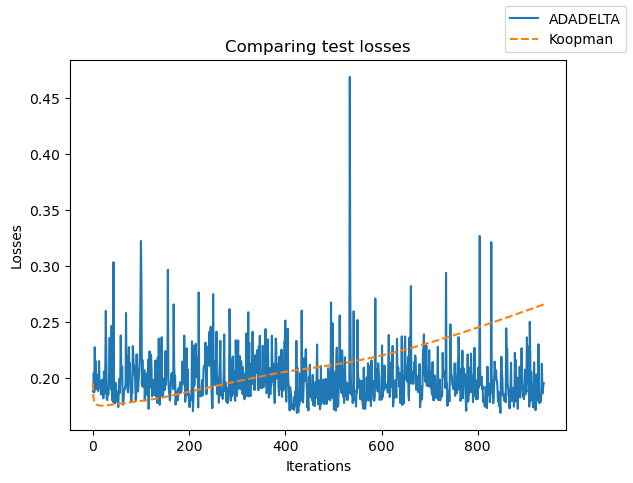

In [11]:
fig, ax = plt.subplots()
ax.plot(conv_test_losses, label = OPTIM)
ax.plot(koop_test_losses, linestyle = 'dashed', label = 'Koopman')
ax.set(xlabel='Iterations', ylabel='Losses', title='Comparing test losses')
fig.legend()
plt.show()

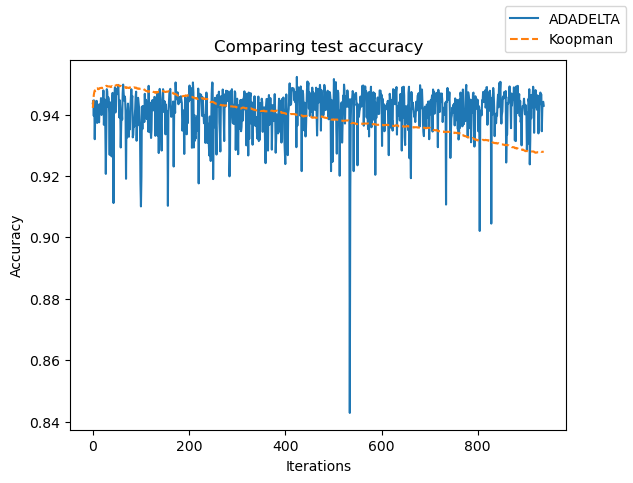

In [12]:
fig, ax = plt.subplots()
ax.plot(conv_test_accs, label = OPTIM)
ax.plot(koop_test_accs, linestyle = 'dashed', label = 'Koopman')
ax.set(xlabel='Iterations', ylabel='Accuracy', title='Comparing test accuracy')
fig.legend()
plt.show()

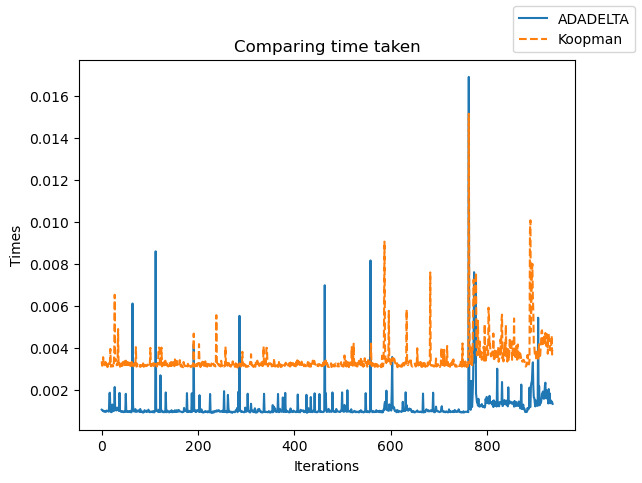

In [13]:
fig, ax = plt.subplots()
ax.plot(conv_times[1:], label = OPTIM)
ax.plot(koop_times[1:], linestyle = 'dashed', label = 'Koopman')
ax.set(xlabel='Iterations', ylabel='Times', title='Comparing time taken')
fig.legend()
plt.show()

**Functions for layerwise Koopman training:**

In [14]:
def build_layer_koopmans(captured_params):
    stacked_captured_params = tree_stack(captured_params)
    koopmans  = []
    for layer in stacked_captured_params.layers:
        F = eqx.filter_vmap(ravel_pytree, in_axes=0)(layer)[0].T
        U = F[:, 1:] @ jnp.linalg.pinv(F[:, :-1])
        koopmans.append(U)
    return koopmans

@eqx.filter_jit
def layer_koopman_update(model, koopmans):
    params, static = eqx.partition(model, eqx.is_array)
    _, meta = ravel_pytree(params)
    layers = []
    for i, layer in enumerate(params.layers):
        flat, _ = ravel_pytree(layer)
        layers.append(koopmans[i] @ flat)
    params = unravel_pytree(jnp.concat(layers), meta)
    return eqx.combine(params, static)

In [15]:
koop_times = []
koop_test_accs = []
koop_test_losses = []
koopmans = build_layer_koopmans(captured_params)
model_k = model_chckpt

for epoch in range(t2, t2 + T):
    for step, (x, y) in enumerate(trainloader):
        x, y  = x.numpy(), y.numpy()
        start = time.time()
        model_k = layer_koopman_update(model_k, koopmans)
        end = time.time()

        koop_test_loss, koop_test_accuracy = evaluate(model_k, testloader)
        koop_times.append(end-start)
        koop_test_accs.append(koop_test_accuracy)
        koop_test_losses.append(koop_test_loss)

**Functions for Network Koopman training**

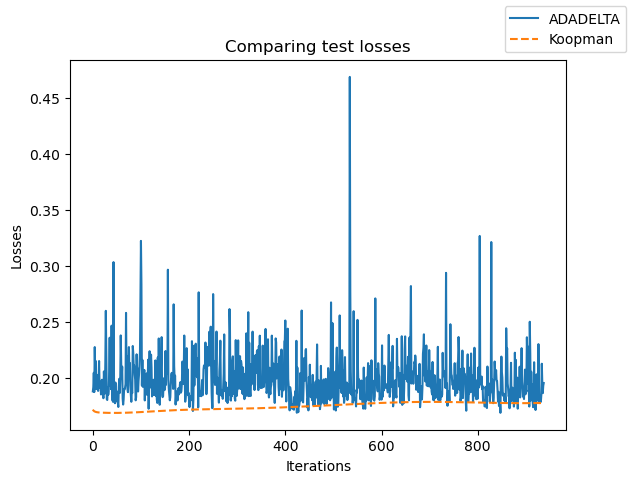

In [16]:
fig, ax = plt.subplots()
ax.plot(conv_test_losses, label = OPTIM)
ax.plot(koop_test_losses, linestyle = 'dashed', label = 'Koopman')
ax.set(xlabel='Iterations', ylabel='Losses', title='Comparing test losses')
fig.legend()
plt.show()

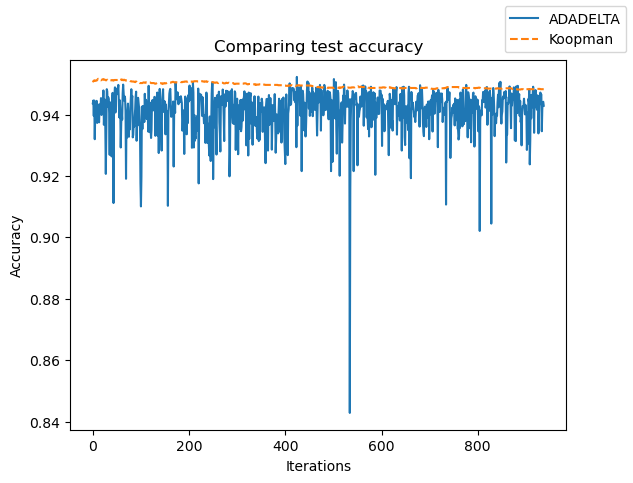

In [17]:
fig, ax = plt.subplots()
ax.plot(conv_test_accs, label = OPTIM)
ax.plot(koop_test_accs, linestyle = 'dashed', label = 'Koopman')
ax.set(xlabel='Iterations', ylabel='Accuracy', title='Comparing test accuracy')
fig.legend()
plt.show()

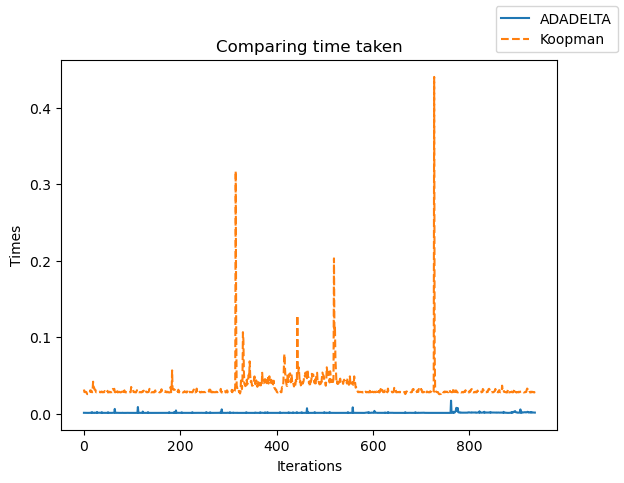

In [18]:
fig, ax = plt.subplots()
ax.plot(conv_times[1:], label = OPTIM)
ax.plot(koop_times[1:], linestyle = 'dashed', label = 'Koopman')
ax.set(xlabel='Iterations', ylabel='Times', title='Comparing time taken')
fig.legend()
plt.show()